In [67]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import re,string,unicodedata
from collections import Counter
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sifan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sifan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sifan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("2022-07-03-IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
Counter(df["sentiment"])

Counter({'positive': 25000, 'negative': 25000})

In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.drop_duplicates(inplace = True)
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [7]:
Counter(df["sentiment"])

Counter({'positive': 24884, 'negative': 24698})

In [8]:
data_copy=df.copy()

## VADER before Preprocess

In [9]:
sia = SentimentIntensityAnalyzer()

In [10]:
sentence = ['I like you']
analyzer = SentimentIntensityAnalyzer()
vs = analyzer.polarity_scores('I like you')
print("{0}:{1}".format(sentence, str(vs)))

['I like you']:{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.3612}


In [11]:
df_v = df.copy()
df_v['scores'] = df_v['review'].apply(lambda review: sia.polarity_scores(review))

In [12]:
df_v

,review,sentiment,scores
0,One of the other reviewers has mentioned that ...,positive,"{'neg': 0.203, 'neu': 0.748, 'pos': 0.048, 'co..."
1,A wonderful little production. <br /><br />The...,positive,"{'neg': 0.053, 'neu': 0.776, 'pos': 0.172, 'co..."
2,I thought this was a wonderful way to spend ti...,positive,"{'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'co..."
3,Basically there's a family where a little boy ...,negative,"{'neg': 0.138, 'neu': 0.797, 'pos': 0.065, 'co..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"{'neg': 0.052, 'neu': 0.801, 'pos': 0.147, 'co..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,"{'neg': 0.047, 'neu': 0.753, 'pos': 0.199, 'co..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"{'neg': 0.166, 'neu': 0.72, 'pos': 0.114, 'com..."
49997,I am a Catholic taught in parochial elementary...,negative,"{'neg': 0.208, 'neu': 0.683, 'pos': 0.108, 'co..."
49998,I'm going to have to disagree with the previou...,negative,"{'neg': 0.105, 'neu': 0.813, 'pos': 0.082, 'co..."


In [13]:
df_v['compound'] = df_v['scores'].apply(lambda comp: comp['compound'])
df_v['comp_score'] = df_v['compound'].apply(lambda c: 1 if c >= 0 else 0)
df_v['sentiment'] = df_v['sentiment'].map({'positive':1,'negative':0})

In [14]:
df_v.head()

,review,sentiment,scores,compound,comp_score
0,One of the other reviewers has mentioned that ...,1,"{'neg': 0.203, 'neu': 0.748, 'pos': 0.048, 'co...",-0.9951,0
1,A wonderful little production. <br /><br />The...,1,"{'neg': 0.053, 'neu': 0.776, 'pos': 0.172, 'co...",0.9641,1
2,I thought this was a wonderful way to spend ti...,1,"{'neg': 0.094, 'neu': 0.714, 'pos': 0.192, 'co...",0.9605,1
3,Basically there's a family where a little boy ...,0,"{'neg': 0.138, 'neu': 0.797, 'pos': 0.065, 'co...",-0.9213,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"{'neg': 0.052, 'neu': 0.801, 'pos': 0.147, 'co...",0.9744,1


In [15]:
Counter(df_v["comp_score"])

Counter({0: 16830, 1: 32752})

In [16]:
f1 = f1_score(df_v['sentiment'],df_v['comp_score'],pos_label=1)
accuracy = accuracy_score(df_v['sentiment'],df_v['comp_score'])

print(f"Validation F1 Score  : {f1} and Accuracy Score {accuracy}")

Validation F1 Score  : 0.7392254840724547 and Accuracy Score 0.6968657980718809


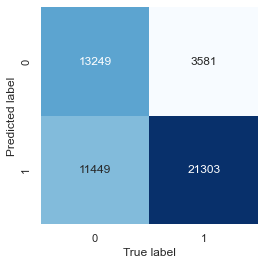

In [17]:
mat = confusion_matrix(df_v['sentiment'],df_v['comp_score'])
# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.show();

## Preprocess

In [18]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

In [19]:
#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    
    return text

In [20]:
df['review']=df['review'].apply(clean_text,lemmatize = True)
df['sentiment'] = df['sentiment'].map({'positive':1,'negative':0})
df

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job creative original...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,going disagree previous comment side maltin on...,0


In [21]:
positive_data = df[df.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
negative_data = df[df.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)

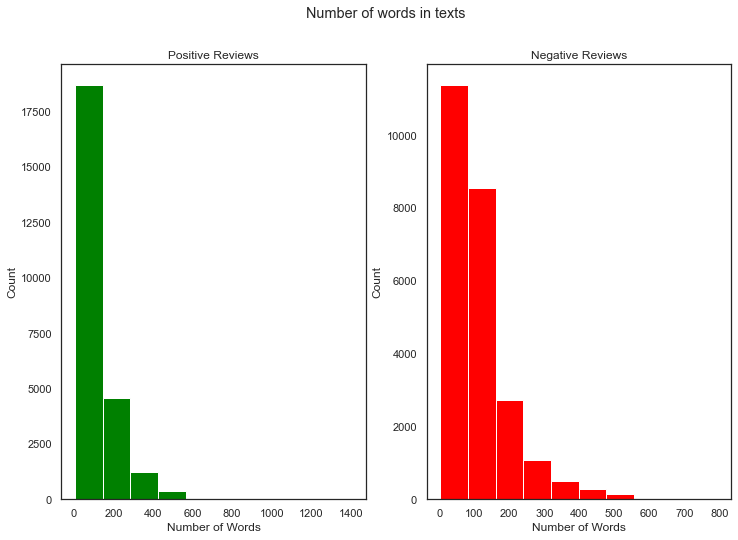

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


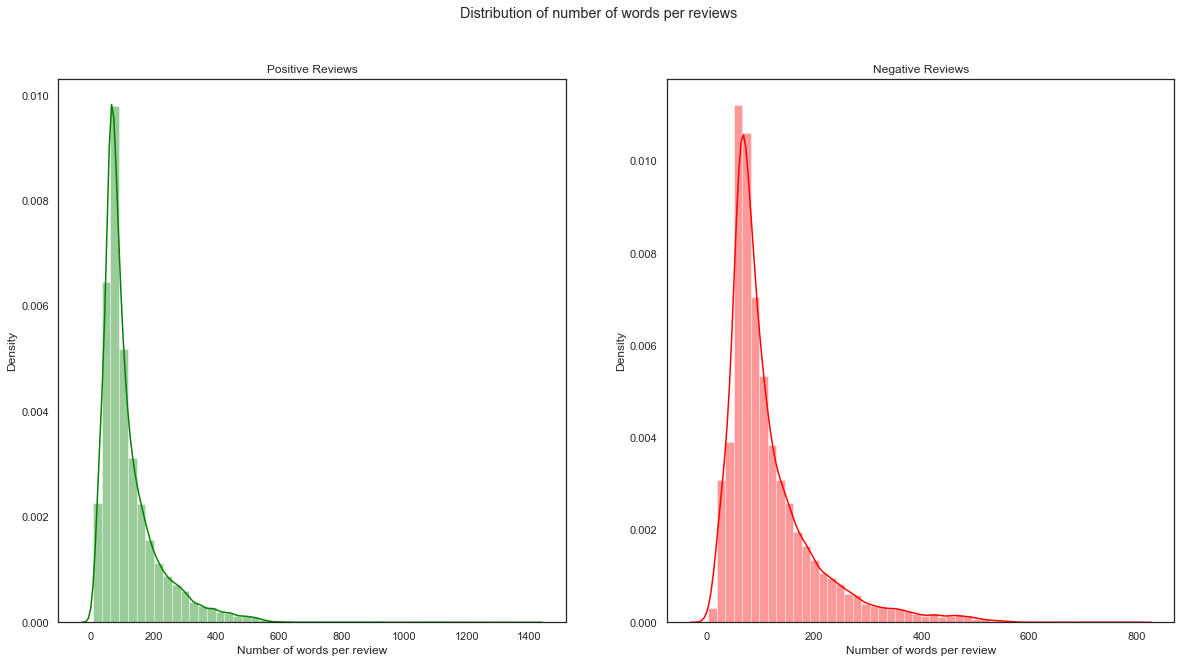

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

In [24]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [25]:
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movie,100605
1,film,91130
2,one,53525
3,like,39746
4,time,30091
5,would,30037
6,good,28905
7,character,27801
8,story,24600
9,even,24440


In [26]:
most_common = most_common.sort_values('countv')

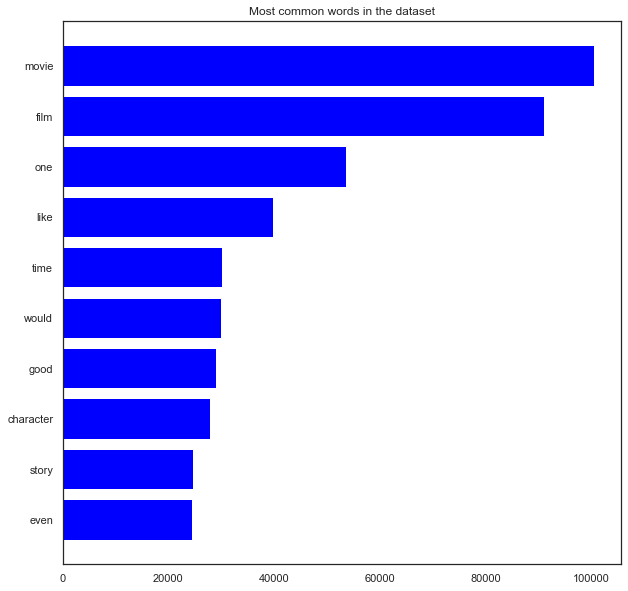

In [27]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [28]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

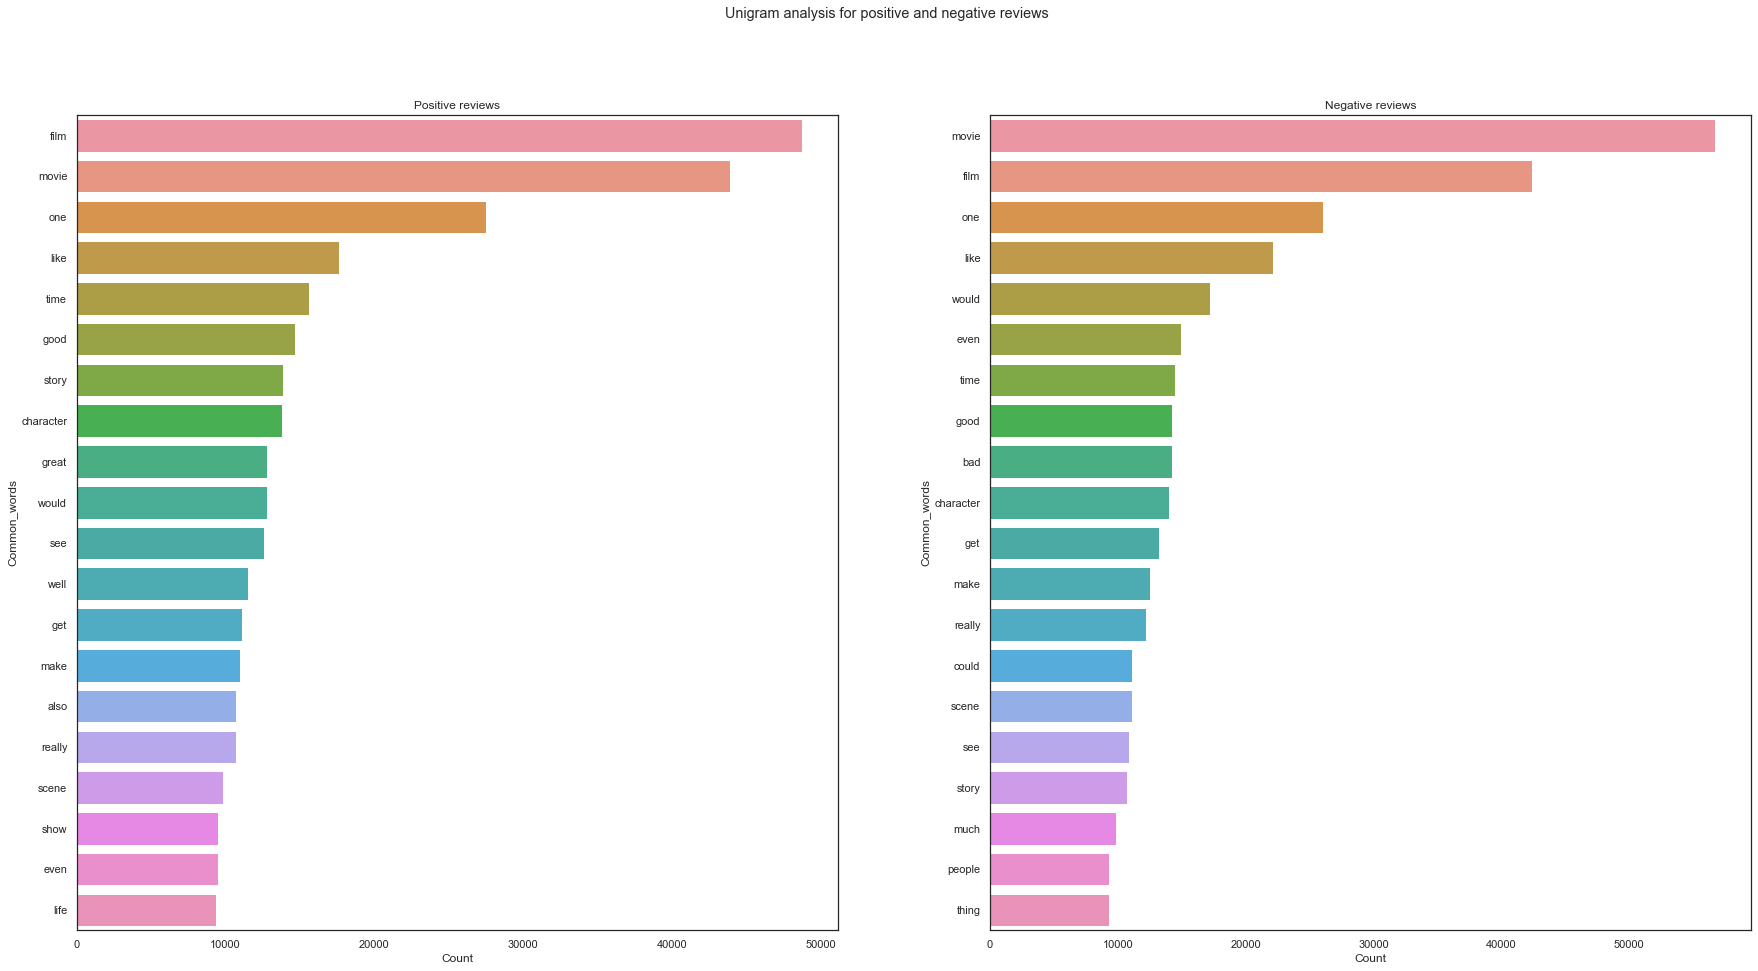

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()

## VADER after Proprocess

In [30]:
df_v = df.copy()
df_v['scores'] = df_v['review'].apply(lambda review: sia.polarity_scores(review))

In [31]:
df_v

,review,sentiment,scores
0,one reviewer mentioned watching oz episode hoo...,1,"{'neg': 0.31, 'neu': 0.576, 'pos': 0.115, 'com..."
1,wonderful little production filming technique ...,1,"{'neg': 0.079, 'neu': 0.635, 'pos': 0.285, 'co..."
2,thought wonderful way spend time hot summer we...,1,"{'neg': 0.149, 'neu': 0.513, 'pos': 0.338, 'co..."
3,basically family little boy jake think zombie ...,0,"{'neg': 0.237, 'neu': 0.626, 'pos': 0.137, 'co..."
4,petter matteis love time money visually stunni...,1,"{'neg': 0.031, 'neu': 0.695, 'pos': 0.274, 'co..."
...,...,...,...
49995,thought movie right good job creative original...,1,"{'neg': 0.064, 'neu': 0.582, 'pos': 0.355, 'co..."
49996,bad plot bad dialogue bad acting idiotic direc...,0,"{'neg': 0.346, 'neu': 0.429, 'pos': 0.226, 'co..."
49997,catholic taught parochial elementary school nu...,0,"{'neg': 0.238, 'neu': 0.543, 'pos': 0.219, 'co..."
49998,going disagree previous comment side maltin on...,0,"{'neg': 0.168, 'neu': 0.695, 'pos': 0.137, 'co..."


In [32]:
df_v['compound'] = df_v['scores'].apply(lambda comp: comp['compound'])
df_v['comp_score'] = df_v['compound'].apply(lambda c: 1 if c >= 0 else 0)
df_v

,review,sentiment,scores,compound,comp_score
0,one reviewer mentioned watching oz episode hoo...,1,"{'neg': 0.31, 'neu': 0.576, 'pos': 0.115, 'com...",-0.9921,0
1,wonderful little production filming technique ...,1,"{'neg': 0.079, 'neu': 0.635, 'pos': 0.285, 'co...",0.9606,1
2,thought wonderful way spend time hot summer we...,1,"{'neg': 0.149, 'neu': 0.513, 'pos': 0.338, 'co...",0.9688,1
3,basically family little boy jake think zombie ...,0,"{'neg': 0.237, 'neu': 0.626, 'pos': 0.137, 'co...",-0.9061,0
4,petter matteis love time money visually stunni...,1,"{'neg': 0.031, 'neu': 0.695, 'pos': 0.274, 'co...",0.9887,1
...,...,...,...,...,...
49995,thought movie right good job creative original...,1,"{'neg': 0.064, 'neu': 0.582, 'pos': 0.355, 'co...",0.9834,1
49996,bad plot bad dialogue bad acting idiotic direc...,0,"{'neg': 0.346, 'neu': 0.429, 'pos': 0.226, 'co...",-0.9129,0
49997,catholic taught parochial elementary school nu...,0,"{'neg': 0.238, 'neu': 0.543, 'pos': 0.219, 'co...",-0.8416,0
49998,going disagree previous comment side maltin on...,0,"{'neg': 0.168, 'neu': 0.695, 'pos': 0.137, 'co...",-0.6597,0


In [33]:
Counter(df_v["comp_score"])

Counter({0: 14889, 1: 34693})

In [34]:
f1_v = f1_score(df_v['sentiment'],df_v['comp_score'],pos_label=1)
accuracy_v = accuracy_score(df_v['sentiment'],df_v['comp_score'])

print(f"Validation F1 Score  : {f1_v} and Accuracy Score {accuracy_v}")

Validation F1 Score  : 0.7280997700454873 and Accuracy Score 0.6732886934774717


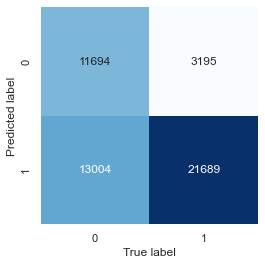

In [35]:
mat1 = confusion_matrix(df_v['sentiment'],df_v['comp_score'])
# Plot Confusion matrix
sns.heatmap(mat1.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.show();

## Naive Bayes

In [36]:
df_b = df.copy()
df_b_train, df_b_test = train_test_split(df_b, test_size=0.2, random_state=42)

In [37]:
# Create a function to calculate the prior probability of each class
def prior_probabilities(df):
    num_positive = len(df[df['sentiment'] == 1])
    num_negative = len(df[df['sentiment'] == 0])
    total = num_positive + num_negative
    return {1: num_positive/total, 0: num_negative/total}

# Create a function to calculate the conditional probability of each word given each class
def conditional_probabilities(df):
    # Create a set of all the unique words in the training data
    all_words = set()
    for text in df['review']:
        all_words.update(text.split())
    # Count the number of occurrences of each word in each class
    counts = {}
    for sentiment in [1, 0]:
        counts[sentiment] = {word: 0 for word in all_words}
        for text in df[df['sentiment'] == sentiment]['review']:
            for word in text.split():
                counts[sentiment][word] += 1
    # Calculate the conditional probabilities
    cond_probs = {}
    for sentiment in [1, 0]:
        cond_probs[sentiment] = {}
        num_words_in_class = sum(counts[sentiment].values())
        for word in all_words:
            cond_probs[sentiment][word] = (counts[sentiment][word] + 1) / (num_words_in_class + len(all_words))
    return cond_probs

prior_probs = prior_probabilities(df_b_train)
cond_probs = conditional_probabilities(df_b_train)

In [38]:
# Create a function to classify new reviews
def classify(text):
    words = text.split()
    probs = {}
    for sentiment in [1, 0]:
        probs[sentiment] = np.log(prior_probs[sentiment])
        for word in words:
            if word in cond_probs[sentiment]:
                probs[sentiment] += np.log(cond_probs[sentiment][word])
            else:
                probs[sentiment] += np.log(1/(sum(cond_probs[sentiment].values()) + len(cond_probs[sentiment])))
                
    if probs[1] > probs[0]:
        return 1
    else:
        return 0
# Test the classifier on the test set
df_b_test['predicted_sentiment'] = df_b_test['review'].apply(classify)
df_b_test

C:\Users\Sifan\AppData\Local\Temp/ipykernel_5832/3835320006.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_test['predicted_sentiment'] = df_b_test['review'].apply(classify)


,review,sentiment,predicted_sentiment
29171,soul plane horrible attempt comedy appeal peop...,0,0
43589,guest future tell fascinating story time trave...,1,1
38712,national treasure thoroughly misguided hodgepo...,0,1
16045,ok first said wanted check whether movie avera...,0,0
5248,always fan show grew season started see richne...,1,1
...,...,...,...
2923,kennedymiller could hardly done better job tac...,1,1
15292,disney studio remake slapstick classic concern...,0,1
17849,gave star possible went realizing discovered a...,0,0
38079,found tremendously disappointing version charm...,0,1


In [39]:
Counter(df_b_test["predicted_sentiment"])

Counter({0: 5082, 1: 4835})

In [40]:
f1_b = f1_score(df_b_test['sentiment'],df_b_test['predicted_sentiment'],pos_label=1)
accuracy_b = accuracy_score(df_b_test['sentiment'],df_b_test['predicted_sentiment'])

print(f"Validation F1 Score  : {f1_b} and Accuracy Score {accuracy_b}")

Validation F1 Score  : 0.8572302048303271 and Accuracy Score 0.8587274377331855


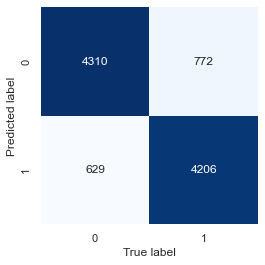

In [41]:
mat2 = confusion_matrix(df_b_test['sentiment'],df_b_test['predicted_sentiment'])
# Plot Confusion matrix
sns.heatmap(mat2.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.show();

## LSTM

In [42]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [43]:
#splitting into train and test
data_copy['review']=data_copy['review'].apply(clean_text,lemmatize = False)
#converting target variable to numerical value
data_copy['sentiment'] = data_copy['sentiment'].map({'positive':1,'negative':0})

In [44]:
data_copy

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job creative original...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary schools n...,0
49998,going disagree previous comment side maltin on...,0


In [45]:
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [46]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  136569


In [47]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [48]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [49]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [50]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.51 % of data


In [51]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [52]:
#Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [53]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
#     #early_stop = EarlyStopping(monitor='val_accuracy', 
#                                mode='min', 
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs

In [54]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 293)]             0         
                                                                 
 embedding (Embedding)       (None, 293, 64)           8740480   
                                                                 
 batch_normalization (BatchN  (None, 293, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 293, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 289, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 289, 32)           0         
                                  

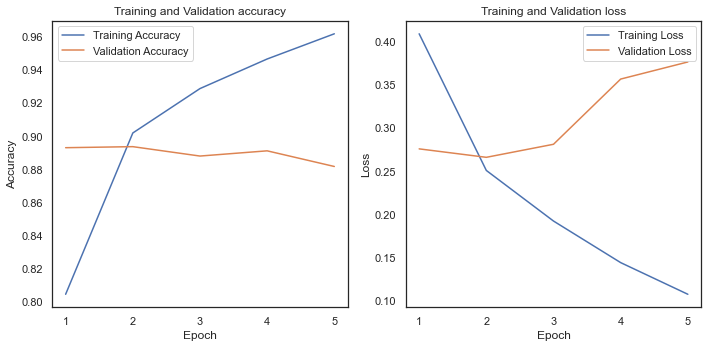

In [55]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [56]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 14s 45ms/step - loss: 0.3818 - accuracy: 0.8757
{'loss': 0.3817952573299408, 'accuracy': 0.8756680488586426}


In [57]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5

310/310 [==============================] - 13s 39ms/step


In [58]:
test['predicted_sentiment'] = ypred

C:\Users\Sifan\AppData\Local\Temp/ipykernel_5832/834542198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_sentiment'] = ypred


In [59]:
test['predicted_sentiment'] = test['predicted_sentiment'].apply(lambda c: 1 if c == True else 0)

C:\Users\Sifan\AppData\Local\Temp/ipykernel_5832/1677880173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_sentiment'] = test['predicted_sentiment'].apply(lambda c: 1 if c == True else 0)


In [60]:
test

,review,sentiment,predicted_sentiment
29171,soul plane horrible attempt comedy appeal peop...,0,0
43589,guest future tells fascinating story time trav...,1,1
38712,national treasure thoroughly misguided hodgepo...,0,1
16045,ok first said wanted check whether movie avera...,0,0
5248,always fan show grew season started see richne...,1,1
...,...,...,...
2923,kennedymiller could hardly done better job tac...,1,1
15292,disney studios remake slapstick classic concer...,0,0
17849,gave stars possible went realizing discovered ...,0,0
38079,found tremendously disappointing version charm...,0,0


In [61]:
Counter(test["sentiment"])

Counter({0: 4939, 1: 4978})

In [62]:
Counter(test["predicted_sentiment"])

Counter({0: 4466, 1: 5451})

In [63]:
f1_l = f1_score(test['sentiment'],test['predicted_sentiment'],pos_label=1)
accuracy_l = accuracy_score(test['sentiment'],test['predicted_sentiment'])

print(f"Validation F1 Score  : {f1_l} and Accuracy Score {accuracy_l}")

Validation F1 Score  : 0.8817719819733435 and Accuracy Score 0.8756680447716043


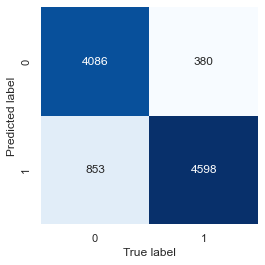

In [64]:
mat3 = confusion_matrix(test['sentiment'],test['predicted_sentiment'])
# Plot Confusion matrix
sns.heatmap(mat3.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.show();

## Compare

In [68]:
f1_and_acc = {'F1 score':{'VADER':f1,'Naive Bayes':f1_b,'LSTM':f1_l},
       'Accuracy':{'VADER':accuracy,'Naive Bayes':accuracy_b,'LSTM':accuracy_l}}
f1_and_acc = DataFrame(f1_and_acc)
f1_and_acc

,F1 score,Accuracy
VADER,0.739225,0.696866
Naive Bayes,0.857230,0.858727
LSTM,0.881772,0.875668
